# Movie Review Sentiment Classification Model

I will be getting my training data from user reviews on Rotten Tomatoes, a review-aggreagation website for films and tv. First I will need to know what movies I will be getting user reviews from. I choose get reviews from the most popular highest and lowest rated movies to ensure that there would be a good variety of positive and negative reviews.

In [1]:
from urllib import request
from bs4 import BeautifulSoup

rt_popular_movies_url = request.urlopen('https://www.rottentomatoes.com/browse/movies_at_home/sort:popular?page=5').read()
pop_movie_soup = BeautifulSoup(rt_popular_movies_url)

pop_movie_container = pop_movie_soup.find('div',{'class':'discovery-tiles','data-id':'movies_at_home_sort:popular'})
movie_hrefs = []
for href in pop_movie_container.find_all('a',href = True):
    movie_hrefs.append(href['href'])

rt_bad_popular_movies = request.urlopen('https://www.rottentomatoes.com/browse/movies_at_home/audience:spilled~sort:popular?page=5').read()
bad_movie_soup = BeautifulSoup(rt_bad_popular_movies)

bad_movie_container = bad_movie_soup.find('div',{'class':'discovery-tiles','data-id':'movies_at_home_audience:spilled~sort:popular'})
for href in bad_movie_container.find_all('a',href = True):
    movie_hrefs.append(href['href'])

Now that we have hrefs for the movies we will remove any duplicates and change each href into a direct link to the movie's user reviews.

In [2]:
movie_hrefs = list(set(movie_hrefs))
movie_review_links = []
for href in movie_hrefs:
    temp_link = 'https://www.rottentomatoes.com' + href + '/reviews?type=user'
    movie_review_links.append(temp_link)

print('There {} movie links. An example of one is below.'.format(len(movie_review_links)))
movie_review_links[0]

There 261 movie links. An example of one is below.


'https://www.rottentomatoes.com/m/the_assistant_2020/reviews?type=user'

Now that we have all of the links to the movies user reviews we just need to scrape them now from each movies' user review page. Below the function *get_reviews* will go to each review link and retrieve the movies genres, user review text, and the corresponding star rating out of 5 for each review on the page. Then it will click the next page button and continue the process until there are no more reviews or it hits number of the max review pages. It will return a dictionary containing all of the information for each review.

In [12]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

def get_reviews(driver,link,max_pages):
    # Input: webdriver, a link for a rotten tomatoes user reviews page, maximum number of pages to click through
    # Output: a list of dictionaries containing the review text and corresponding rating

    master_reviews = []
    button_xpath = "//button[@data-direction='next' and span='Next']"
    try:
        driver.get(link) # driver finds link
    except:
        print('Error: Problem with loading link: {}'.format(link))
    else:
        print('{} has been loaded'.format(link.split('/')[4]))
        movie_details_element = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.XPATH,"//ul[@data-qa='sidebar-movie-details']")))
        genres_element = movie_details_element.find_elements(By.TAG_NAME,'li') # get movie's genres
        movie_details = []
        for detail in genres_element:
            movie_details.append(detail.text)
        genres = movie_details[1].split(',')

        num_pages = 0
        while(num_pages < max_pages): # start to click through reviews pages
            try:
                review_texts = WebDriverWait(driver,10).until(EC.presence_of_all_elements_located((By.XPATH,"//p[@data-qa='review-text']"))) # find reviews text
                review_ratings = WebDriverWait(driver,10).until(EC.presence_of_all_elements_located((By.CLASS_NAME,"star-display"))) # find reviews ratings
            except:
                print('\t--- Error finding reviews ---')
                break # go to next link if problem finding reviews
            else:
                attemps = 0
                while(attemps < 3): # multiple attemps due to problems with loading page info
                    try:
                        text_list = []
                        for text in review_texts:
                            text_list.append(text.text)
                        
                        ratings_list = []
                        for rating in review_ratings: # calculate star rating
                            filled_stars = rating.find_elements(By.CLASS_NAME,'star-display__filled')
                            half_stars = rating.find_elements(By.CLASS_NAME,'star-display__half')
                        
                            rating = len(filled_stars) + len(half_stars)/2
                            ratings_list.append(rating)
                    except:
                        attemps += 1
                    else:
                        for i in range(len(text_list)):
                            master_reviews.append({'review':text_list[i],'rating':ratings_list[i],'genres':genres})
                        break
                try: # click next button to go to next review page
                    next_button = driver.find_element(By.XPATH,button_xpath)
                    next_button.click()
                except:
                    break # button not found, either end of reviews or page has no reviews
                num_pages += 1
    return master_reviews

In [31]:
serv = Service('/Users/zacfishbein/chromedriver')
driver = webdriver.Chrome(service = serv)

reviews_list = []
for link in movie_review_links:
    reviews = get_reviews(driver,link,20)
    reviews_list.append(reviews)
driver.close()

orphan_first_kill has been loaded
under_the_skin_2013 has been loaded
lightyear has been loaded
the_next_365_days has been loaded
avatar has been loaded
happening has been loaded
hereditary has been loaded
running_with_the_devil_the_wild_world_of_john_mcafee has been loaded
hellbender has been loaded
no_exit_2022 has been loaded
im_thinking_of_ending_things has been loaded
infinite has been loaded
no_sudden_move has been loaded
zack_snyders_justice_league has been loaded
piranha_3d has been loaded
star_wars_the_rise_of_skywalker has been loaded
whiplash_2014 has been loaded
the_sadness_2021 has been loaded
blood_red_sky has been loaded
365_days_2020 has been loaded
the_harder_they_fall has been loaded
tenet has been loaded
mrs_harris_goes_to_paris has been loaded
the_adam_project has been loaded
purple_hearts_2022 has been loaded
interstellar_2014 has been loaded
pirates_of_the_caribbean_on_stranger_tides has been loaded
wedding_season has been loaded
kimi has been loaded
the_nice_guys

Now that we have all of the reviews we will unpack each individual movie reviews list into a master list.

In [ ]:
# to unlist elements
reviews = []
for i in range(len(reviews_list)):
    for j in range(len(reviews_list[i])):
        reviews.append(reviews_list[i][j])

Now that we have all of the reviews we will make a couple classes to better organize the data. First is just the simple *Review* class where each review will become an object of the class with its basic information, review text, star rating, genres, and sentiment. The sentiment is decided as positve if the rating is higher than 2.5 and negative it is below that. Then there is the *ReviewBucket* class which is where all of the *Review* class objects will be stored. With *ReviewBucket* we will be able to access the review text and sentiments, get the vectorized review text for the classification model (which I will do more in depth soon), get current genres and filter for specific ones, get the distribution of positive and negative reviews in the ReviewBucket, and make the number of positive and negative even for better model preformance.

In [20]:
import random
import pickle

class Sentiment:
    POSITIVE = 'POSITIVE'
    NEUTRAL = 'NEUTRAL'
    NEGATIVE = 'NEGATIVE'

class Review:
    def __init__(self,text,rating,genres):
        self.text = text
        self.rating = rating
        self.genres = genres
        self.sentiment = self.get_sentiment()
    
    def get_sentiment(self): # if rating is higher than 2.5 stars is positive, else negtive
        if self.rating > 2.5:
            return Sentiment.POSITIVE
        else:
            return Sentiment.NEGATIVE

class ReviewBucket:
    def __init__(self,reviews):
        self.reviews = reviews

    def get_review_text(self): # returns review text in list
        return [x.text for x in self.reviews]

    def get_sentiment(self): # returns review sentiment in list
        return [x.sentiment for x in self.reviews]

    def get_vectorized_review_text(self,vectorizer): # returns review text as vectorized matrix
        return vectorizer.transform(self.get_review_text())

    def current_genres(self): # get current genres found in review bucket
        genres_master_list = [x.genres for x in self.reviews]
        final_genres_list = []
        for genres_list in genres_master_list: # getting each genres list
            for genre in genres_list: # getting each genre
                if genre not in final_genres_list:
                    final_genres_list.append(genre)
        return final_genres_list
    
    def make_only_contains_genre(self,genre): # filter bucket to only contain certain genres
        new_reviews = []
        for review in self.reviews:
            if genre in review.genres:
                new_reviews.append(review)

        self.reviews = new_reviews
        random.shuffle(self.reviews)

    def make_even(self,num_reviews): # makes number of positive and negative reviews the same
        positive_reviews = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE,self.reviews))
        negative_reviews = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE,self.reviews))

        if num_reviews == 0: # if input num_reviews is an actual number that would want to be used use it, otherwise make even
            max_num_reviews = min(len(positive_reviews),len(negative_reviews)) # finds which sentiment has the most reviews
        else:
            max_num_reviews = num_reviews

        positive_reviews = positive_reviews[:max_num_reviews]
        negative_reviews = negative_reviews[:max_num_reviews]

        self.reviews = positive_reviews + negative_reviews
        random.shuffle(self.reviews)

    def get_distribution(self): # returns number and percent of positive and negative reviews
        positive_count = self.get_sentiment().count(Sentiment.POSITIVE)
        negative_count = self.get_sentiment().count(Sentiment.NEGATIVE)

        total_count = positive_count + negative_count

        pos_per = round((positive_count/total_count) * 100,2)
        neg_per = round((negative_count/total_count) * 100,2)

        return 'Positive: {} ~ {}%\nNegative: {} ~ {}%'\
            .format(positive_count,pos_per,negative_count,neg_per)

First the reviews will be made into a list of objects of the *Review* class.

In [22]:
review_objects_list = []
for i in range(len(reviews_dict_list)): # makes all reviews in dictionary form into list of Review objects
    temp_review = Review(reviews_dict_list[i]['review'],reviews_dict_list[i]['rating'],reviews_dict_list[i]['genres'])
    review_objects_list.append(temp_review)

Now with all of the reviews we will split the reviews into a training and test set, 80% training and 20% test, for our model and look at their current distributions.

In [25]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(review_objects_list, test_size =.2, shuffle = True)# split review objects into training and testing, test 20% of data

training_bucket = ReviewBucket(training)
test_bucket = ReviewBucket(test)

print('Training\n' + training_bucket.get_distribution())
print('\nTest\n'+test_bucket.get_distribution())

Training
Positive: 10998 ~ 60.0%
Negative: 7332 ~ 40.0%

Test
Positive: 2748 ~ 59.96%
Negative: 1835 ~ 40.04%


We wille make the distribution even for the training bucket to improve our model's preformance as there will not be a more weighted category.

In [26]:
training_bucket.make_even(0)
print(training_bucket.get_distribution())

Positive: 7332 ~ 50.0%
Negative: 7332 ~ 50.0%


Now to prepare the data for our model we will use sklearn's CountVectorizer to make a sparse matrix made from each unique word found throughout all of the reviews. Then we will transform all of the review text strings from both the training and test data to the vectorizer where each word found in an individual review will be represented as a 1 in the sparse matrix. This allows for our model to find commonalities in words for different sentiments.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

vectorizer.fit(training_bucket.get_review_text()) # fitting vectorizer word matrix to training review text

# transforming review text to vectorizer (changing to vector matrix)
training_X = training_bucket.get_vectorized_review_text(vectorizer)
test_X = test_bucket.get_vectorized_review_text(vectorizer)

# training and test vibes
training_y = training_bucket.get_sentiment()
test_y = test_bucket.get_sentiment()

All that is left now is to make our model, fit the training data to it, and test its preformance. We see that the model has an accuracy of 90.2% and an f1 score of .916 and .882 for positive and negative reviews, respectively.

In [30]:
from sklearn import svm
from sklearn.metrics import f1_score

clf_model = svm.SVC(kernel='linear')

clf_model.fit(training_X,training_y)

print(clf_model.score(test_X,test_y))

f1_score(clf_model.predict(test_X), test_y, average = None,labels = [Sentiment.POSITIVE,Sentiment.NEGATIVE])

0.902029238490072


array([0.9164029 , 0.88168643])

Looking at the confusion matrix for our model we see that recall = .9117 and precision = .8534. Therefore, the model creates more error by making more Type I errors, so it would be beneficial to reduce the number of false positives.

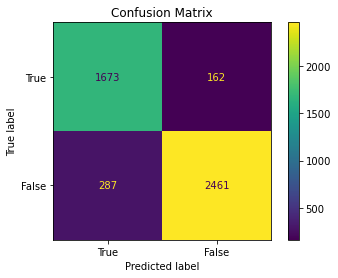

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_y,clf_model.predict(test_X)), display_labels = [True, False])

cm_display.plot()
plt.title('Confusion Matrix')
plt.show()